In [1]:
#importing required libraries
import numpy as np
from docplex.mp.model import Model
import networkx as nx
import docplex.mp.solution as Solution
import matplotlib.pyplot as plt
import time

In [2]:
#function to reverse a tuple
def Reverse(tuples):
    new_tup = tuples[::-1]
    return new_tup


#function to detect cycles from solution and returning nested list of cycles with
#first list containg (0,j)&(i,0)
def cycle_det(active_arcs):
    duplicat_arcs=list()
    for i,j in active_arcs:
        duplicat_arcs.append((i,j))
    cycle_iter_var = 0
    cycle_list = list()
    while True:
        g = nx.Graph()
        g.add_edges_from(duplicat_arcs)
        try:
            cycle = nx.find_cycle(g)
            #print(f'Cycle {cycle_iter_var} is ______{cycle}')
            cycle_list.append(cycle)
        except:
            #print('all arcs done')
            break
        for i,j in cycle:
            duplicat_arcs.remove((i,j))
    cycle_iter_var = cycle_iter_var+1
    cycle_list_start_with_0=[]
    for i in cycle_list:
        for tup in i:
            if tup[0]==0 or tup[1]==0:
                cycle_list_start_with_0.append(i)
                continue
        cycle_list_start_with_0.append(i)
    if len(cycle_list)==1:
        return 0
    else:
        return cycle_list_start_with_0

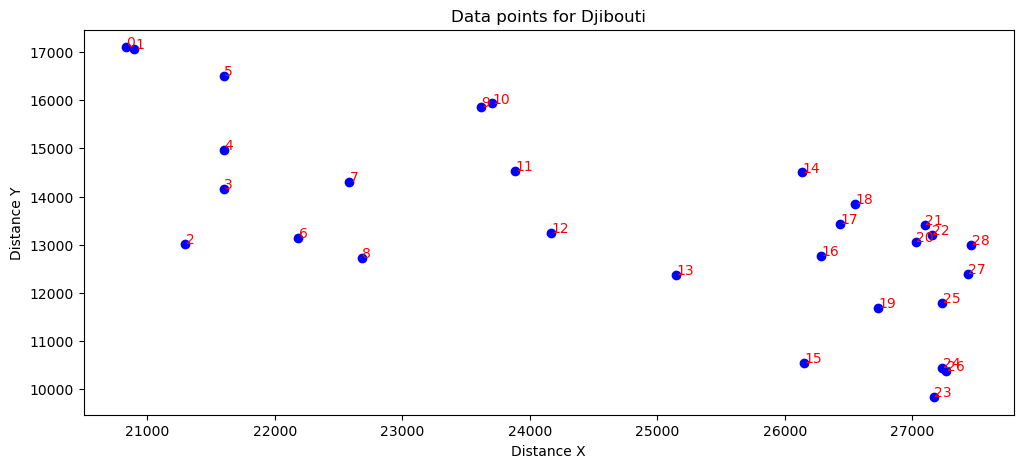

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 406 rows and 0 columns.
Reduced MIP has 464 rows, 812 columns, and 2436 nonzeros.
Reduced MIP has 812 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.82 ticks)
Found incumbent of value 101333.628046 after 0.03 sec. (4.27 ticks)
Probing time = 0.00 sec. (2.16 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 464 rows, 812 columns, and 2436 nonzeros.
Reduced MIP has 812 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.89 ticks)
Probing time = 0.02 sec. (2.16 ticks)
Clique table members: 464.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.96 ticks)

        Nodes   

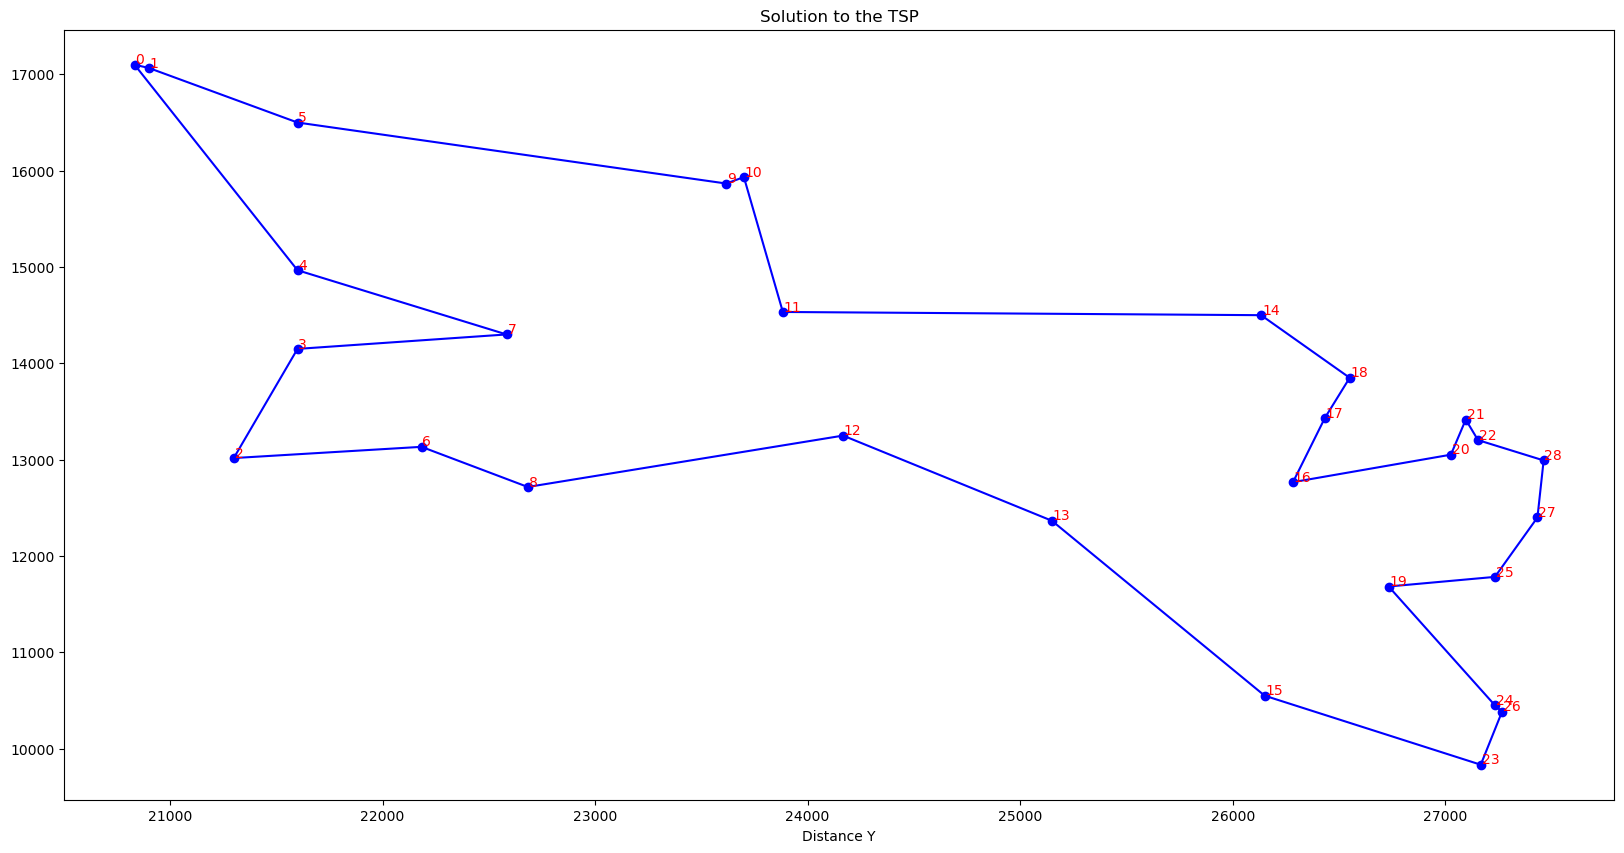

In [3]:
#taking user input
fh = open(input('Enter the name of input file (Remember to put the .txt extension):-'))
#marking start time
start_time = time.time()
#reading the text file
loc_x = list()
loc_y = list()
for i in fh:
    a = i.split()
    loc_x.append(float(a[1]))
    loc_y.append(float(a[2]))
n = len(loc_x)
#creating nodes and edges
cities = [i for i in range(n)]
edges = [(i,j) for i in cities for j in cities if i!=j]
#input plot
plt.figure(figsize=(12,5))
plt.scatter(loc_x,loc_y,color='blue')
plt.xlabel("Distance X")
plt.ylabel("Distance Y")
plt.title("Data points for Djibouti")
s = []
for n in range(len(loc_x)):
    s_temp= []
    s_temp.append("%.lf"%loc_x[n])
    s_temp.append("%.lf"%loc_y[n])
    s.append(s_temp)
#for n in range(len(loc_x)):
#   plt.annotate(str(s[n]),xy=(loc_x[n],loc_y[n]),xytext=(loc_x[n]-4,loc_y[n]-5), color='red')
for n in range(len(loc_x)):
    plt.annotate(str(n),xy=(loc_x[n],loc_y[n]),xytext=(loc_x[n]+4,loc_y[n]+10), color='red')
plt.savefig('input.png')
plt.show()

#Calculate euclidiean distance
distance  = {(i,j):np.hypot(loc_x[i]-loc_x[j],loc_y[i]-loc_y[j]) for i,j in edges}
#defining the model
mdl=Model('MAPTSP38')
#defining variable for model
x = mdl.binary_var_dict(edges,name='x')
#objective function
mdl.minimize(mdl.sum(distance[i]*x[i] for i in edges))
#constraits
#output
for c in cities:
    mdl.add_constraint(mdl.sum(x[i,j] for i,j in edges if i==c)==1, ctname='out_%d'%c)
#input
for c in cities:
    mdl.add_constraint(mdl.sum(x[i,j] for i,j in edges if j==c)==1, ctname='in_%d'%c)
#Subtour elemination 2 cities
for i,j in edges:
    for k,l in edges:
        if i==l:
            if j==k:
                mdl.add_constraint(x[i,j]+x[k,l]<=1, ctname='two_sub_%d'%c)

#solving the problem initially
solution=mdl.solve(log_output=True)
#extracting the active arcs
active_arcs = [i for i in edges if x[i].solution_value>0.9]
#solving in loop that is adding necessary SEC
while True:
    x_1 = cycle_det(active_arcs)
    #breaking the while loop if cycle detected ==1
    if x_1 ==0:
        print('Optimal path found')
        optimal_path = active_arcs
        print('objective value is',solution.get_objective_value())
        print(f'Code take{(time.time()-start_time)} seconds to execute')
        print(f'Active arcs are {optimal_path}')
        break
    else:
        for i in range(len(x_1)-1):
            i = (len(x_1)-1)-i
            sub_cycle = x_1[i]
            #print(sub_cycle)
            mdl.add_constraint(mdl.sum(x[j] for j in sub_cycle)<=len(sub_cycle)-1, ctname='sub_ex%d'%c)
            mdl.add_constraint(mdl.sum(x[Reverse(j)] for j in sub_cycle)<=len(sub_cycle)-1, ctname='sub_ex%d'%c)
        solution = mdl.solve(log_output=True)
        #active_arcs.clear()
        active_arcs = [i for i in edges if x[i].solution_value>0.9]
        #print(f'Active arcs are {active_arcs}')

#plotting the output
plt.figure(figsize=(20,10))
plt.xlabel("Distance X")
plt.xlabel("Distance Y")
plt.title("Solution to the TSP")
plt.scatter(loc_x,loc_y, color = 'blue', zorder=1)
for i,j in active_arcs:
    plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]], color = 'blue', zorder=1)
for n in range(len(loc_x)):
    plt.annotate(str(n),xy=(loc_x[n],loc_y[n]),xytext=(loc_x[n]+4,loc_y[n]+10), color='red')
plt.savefig('output.png')
plt.show()